# Countries Explorative Data Analysis (EDA)

## Overview
The dataset used in this project contains information about all the countries in the world. The objective of the analysis is to gain insights about population, area, languages, side of the road, distribution of wealth, life expectancy, crime index and mortality rate.

## Questions for Analysis

1. What are the 10 most populated countries?
2. What are the most populated country per subregion?
3. What is the least populated continent?
4. What are the top 20 largest countries?
5. What is the smallest continent?
6. What are the top 10 most common languages?
7. What is the proportion of countries driving on the left side vs. right side for each continent?
8. What are the 10 countries with the least inequalities?
9. What are the 10 countries with the highest mortality rate?
10. What is the subregion with the highest crime index?
11. Does inequality cause high crime?
12. What is the overall average life expectancy?
13. What variables seem to be correlated to life expectancy the most?

## About Dataset

The dataset comes from 5 different sources
- [REST Countries API](https://restcountries.com/)
- [World Bank Group](https://datacatalog.worldbank.org/search/dataset/0038130) (dowloaded CSV)
- [Worldometer](https://www.worldometers.info/demographics/life-expectancy/) (web scraping)
- [Numbeo](https://www.numbeo.com/crime/rankings_by_country.jsp?title=2023) (web scraping)
- [CIA](https://www.cia.gov/the-world-factbook/field/death-rate/country-comparison/) (downloaded CSV)

### Columns description
- ```name```: country name
- ```code```: ISO 3166 country code
- ```continent```: continent of the country
- ```subregion```: subregion of the country
- ```population```: population of the country
- ```area```: country area, in square kilometers
- ```languages```: languages spoken
- ```car_side```: side of the traffic (left or right)
- ```gdp```: Gross Domestic Product (GDP), in millions of US Dollars
- ```gdp_per_capita```: Gross Domestic Product per 100,000 people
- ```gini```: GINI Coefficient or GINI Index, measures inequality on a scale from 0 to 100, 0 being perfect equality and 100 being perfect inequality
- ```crime_index```: Crime Severity Index (CSI), summarized police-reported crimes
- ```death_rate```: mortality rate per 1000 people
- ```life_expectancy```: life expectancy for both sexes

## Import libraries

In [7]:
from bs4 import BeautifulSoup
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import time

## Custom Functions

In [9]:
# Create function to write CSV file
def writeCSV(file_name, header, rows):
     with open('Data/' + file_name + '.csv', 'w') as output_file:
            dict_writer = csv.DictWriter(output_file, fieldnames=header)
            dict_writer.writeheader()
            dict_writer.writerows(rows)
            output_file.close()
            print('CSV file', output_file.name, 'created successfully.')

In [10]:
# Create function to scrape table
def scrapeTable(url, table_id, file_name):
    response = requests.get(url)

    if response.status_code != 200:
        print('Failed to fetch page.')
    else:
        soup = BeautifulSoup(response.content)
        table = soup.find('table', {'id': table_id})

        # save the data into a dictionary
        lst = []

        # header
        table_header = table.select('thead tr th')
        keys = list(map(lambda x: x.text, table_header))

         # body
        table_rows = table.find('tbody').find_all('tr')
        
        for row in table_rows:
            table_data = row.select('td')
            row_data = np.array(list(map(lambda x: x.text, table_data)))
            dict_item = {}
            
            for i in range(len(row_data)):
                dict_item[keys[i]] = row_data[i]
            
            lst.append(dict_item)

        # create/replace CSV file
        writeCSV(file_name, keys, lst)

In [11]:
# Create function to return mismatches
def returnNotMatches(a, b):
    return {'a': sorted([x for x in a if x not in b]), 'b': sorted([x for x in b if x not in a])}

## Step 1 - Data Collection

### Create countries CSV file from API

In [14]:
# Handle ChunkedEncodingError by adding 'try except' and adding 1 second pause between each attempt
for attempt in range(3):
    country_list = []
    
    try:
        response = requests.get('https://restcountries.com/v3.1/all')
        
        if response.status_code != 200:
            print('Failed to find data')

        else:
            countriesJson = json.loads(response.content)
    
            # Collect relevant columns
            for item in countriesJson:
                keys = item.keys()
                country = {
                    'name': item['name']['common'],
                    'code': item['cca3'],
                    'continent' : item['region'] if 'subregion' in keys else item['continents'][0],
                    'subregion' : item['subregion'] if 'subregion' in keys else None,
                    'population': item['population'],
                    'area': item['area'],
                    'languages': ', '.join(list(item['languages'].values())) if 'languages' in keys else None,
                    'car_side': item['car']['side'],
                    'gini': list(item['gini'].values())[0] if 'gini' in keys else None
                }
                country_list.append(country)
    
            header = country_list[0].keys()
    
            ## Create/replace CSV file
            writeCSV('countries', header, country_list)
    
        break
    except requests.exceptions.ChunkedEncodingError:
        time.sleep(1)
else:
    print('Failed to fetch data from REST countries API.')

CSV file Data/countries.csv created successfully.


### Create life expectancy and crime index CSV through web scraping

In [16]:
# Scrape life expectancy table
scrapeTable('https://www.worldometers.info/demographics/life-expectancy/', 'example2', 'life_expectancy')

# Scrape crime index table
scrapeTable('https://www.numbeo.com/crime/rankings_by_country.jsp?title=2023', 't2', 'crime_index')

CSV file Data/life_expectancy.csv created successfully.
CSV file Data/crime_index.csv created successfully.


### Create dataframe from the CSV files

In [18]:
# Get number of rows/columns of each dataframe
countries = pd.read_csv('Data/countries.csv')
print('countries shape:', countries.shape)

gdp = pd.read_csv('Data/gdp.csv', on_bad_lines='error')
print('gdp shape:', gdp.shape)

life_expectancy = pd.read_csv('Data/life_expectancy.csv')
print('life_expectancy shape:', life_expectancy.shape)

crime_index = pd.read_csv('Data/crime_index.csv')
print('crime_index shape:', crime_index.shape)

death_rate = pd.read_csv('Data/death_rate.csv')
print('death_rate shape:', death_rate.shape)

countries shape: (250, 9)
gdp shape: (217, 4)
life_expectancy shape: (201, 5)
crime_index shape: (142, 4)
death_rate shape: (229, 7)


In [19]:
# Merge countries with gdp
countries = countries.merge(gdp, how='left', on='code')

In [20]:
# There is no 3 letter code column in life_expectancy, crime_index and death_rate. The only way to merge those dataframes 
# is through the country name column. The countries are not named exactly the same therefore we need 
# to rename them so they match the names of the countries dataframe,
new_list = returnNotMatches(countries['name'].tolist(), life_expectancy['Country'].tolist())
print('Country mismatches:', new_list, '\n')

# create rename dictionary
countries_to_rename = {
    "Brunei ": "Brunei",
    "Cabo Verde": "Cape Verde",
    "Congo": "Republic of the Congo",
    "Czech Republic (Czechia)": "Czechia",
    "Côte d'Ivoire": "Ivory Coast",
    "Macao": "Macau",
    "Sao Tome & Principe": "São Tomé and Príncipe",
    "St. Vincent & Grenadines": "Saint Vincent and the Grenadines",
    "State of Palestine": "Palestine",
    "U.S. Virgin Islands": "United States Virgin Islands"
}

# merge countries with life_expectancy
life_expectancy['Country'] = life_expectancy['Country'].replace(countries_to_rename)
countries = countries.merge(life_expectancy, how='left', left_on='name', right_on='Country')
print('Merged dataframe shape:', countries.shape)

Country mismatches: {'a': ['American Samoa', 'Andorra', 'Anguilla', 'Antarctica', 'Bermuda', 'Bouvet Island', 'British Indian Ocean Territory', 'British Virgin Islands', 'Brunei', 'Cape Verde', 'Caribbean Netherlands', 'Cayman Islands', 'Christmas Island', 'Cocos (Keeling) Islands', 'Cook Islands', 'Czechia', 'Dominica', 'Falkland Islands', 'Faroe Islands', 'French Southern and Antarctic Lands', 'Gibraltar', 'Greenland', 'Guernsey', 'Heard Island and McDonald Islands', 'Isle of Man', 'Ivory Coast', 'Jersey', 'Kosovo', 'Liechtenstein', 'Macau', 'Marshall Islands', 'Monaco', 'Montserrat', 'Nauru', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Palau', 'Palestine', 'Pitcairn Islands', 'Republic of the Congo', 'Saint Barthélemy', 'Saint Helena, Ascension and Tristan da Cunha', 'Saint Kitts and Nevis', 'Saint Martin', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'San Marino', 'Sint Maarten', 'South Georgia', 'Svalbard and Jan Mayen', 'São Tomé and Príncipe', 'Tok

In [21]:
# Same method for crime_index
new_list = returnNotMatches(countries['name'].tolist(), crime_index['Country'].tolist())
print('Country mismatches:', new_list, '\n')

countries_to_rename = {
    "Bosnia And Herzegovina": "Bosnia and Herzegovina",
    "Czech Republic": "Czechia",
    "Hong Kong (China)": "Hong Kong",
    "Isle Of Man": "Isle of Man",
    "Kosovo (Disputed Territory)": "Kosovo",
    "Taiwan (China)": "Taiwan",
    "Trinidad And Tobago": "Trinidad and Tobago",
    "Us Virgin Islands": "United States Virgin Islands"
}

# merge countries with crime_index
crime_index['Country'] = crime_index['Country'].replace(countries_to_rename)
countries = countries.merge(crime_index, how='left', left_on='name', right_on='Country')
print('Merged dataframe shape:', countries.shape)

Country mismatches: {'a': ['American Samoa', 'Andorra', 'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Aruba', 'Benin', 'Bermuda', 'Bhutan', 'Bosnia and Herzegovina', 'Bouvet Island', 'British Indian Ocean Territory', 'British Virgin Islands', 'Burkina Faso', 'Burundi', 'Cape Verde', 'Caribbean Netherlands', 'Cayman Islands', 'Central African Republic', 'Chad', 'Christmas Island', 'Cocos (Keeling) Islands', 'Comoros', 'Cook Islands', 'Curaçao', 'Czechia', 'DR Congo', 'Djibouti', 'Dominica', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Falkland Islands', 'Faroe Islands', 'French Guiana', 'French Polynesia', 'French Southern and Antarctic Lands', 'Gabon', 'Gambia', 'Gibraltar', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guernsey', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Heard Island and McDonald Islands', 'Hong Kong', 'Isle of Man', 'Ivory Coast', 'Jersey', 'Kiribati', 'Kosovo', 'Laos', 'Lesotho', 'Liberia', 'Liechtenstein', 'Macau', 'Madagascar', 'Malawi', 'Mali', 'Marshall Islands'

In [22]:
# Same method for death_rate
new_list = returnNotMatches(countries['name'].tolist(), death_rate['name'].tolist())
print('Country mismatches:', new_list, '\n')

countries_to_rename = {
    "Bahamas, The": "Bahamas",
    "Burma": "Myanmar",
    "Cabo Verde": "Cape Verde",
    "Congo, Democratic Republic of the": "DR Congo",
    "Congo, Republic of the": "Republic of the Congo",
    "Cote d'Ivoire": "Ivory Coast",
    "Curacao": "Curaçao",
    "Falkland Islands (Islas Malvinas)": "Falkland Islands",
    "Gambia, The": "Gambia",
    "Korea, North": "North Korea",
    "Korea, South": "South Korea",
    "Micronesia, Federated States of": "Micronesia",
    "Saint Barthelemy": "Saint Barthélemy",
    "Saint Helena, Ascension, and Tristan da Cunha": "Saint Helena, Ascension and Tristan da Cunha",
    "Sao Tome and Principe": "São Tomé and Príncipe",
    "Turkey (Turkiye)": "Turkey",
    "Virgin Islands": "United States Virgin Islands"
}

# merge countries with death_rate
death_rate['name'] = death_rate['name'].replace(countries_to_rename)
countries = countries.merge(death_rate, how='left', on='name')
print('Merged dataframe shape:', countries.shape)

Country mismatches: {'a': ['Antarctica', 'Bahamas', 'Bouvet Island', 'British Indian Ocean Territory', 'Cape Verde', 'Caribbean Netherlands', 'Christmas Island', 'Curaçao', 'DR Congo', 'Falkland Islands', 'French Guiana', 'French Southern and Antarctic Lands', 'Gambia', 'Guadeloupe', 'Heard Island and McDonald Islands', 'Ivory Coast', 'Martinique', 'Mayotte', 'Micronesia', 'Micronesia', 'Myanmar', 'Niue', 'Norfolk Island', 'North Korea', 'Palestine', 'Pitcairn Islands', 'Republic of the Congo', 'Réunion', 'Saint Barthélemy', 'Saint Helena, Ascension and Tristan da Cunha', 'South Georgia', 'South Korea', 'Svalbard and Jan Mayen', 'São Tomé and Príncipe', 'Tokelau', 'Turkey', 'United States Minor Outlying Islands', 'United States Virgin Islands', 'Vatican City', 'Western Sahara', 'Åland Islands'], 'b': ['Bahamas, The', 'Burma', 'Cabo Verde', 'Congo, Democratic Republic of the', 'Congo, Republic of the', "Cote d'Ivoire", 'Curacao', 'Falkland Islands (Islas Malvinas)', 'Gambia, The', 'Gaza

## Step 2 - Data Exploration

In [24]:
# Remove scientific notation and keep 2 decimals
pd.options.display.float_format = '{:.2f}'.format

In [25]:
countries.sample(5)

,name,code,continent,subregion,population,area,languages,car_side,gini,rank,...,Rank,Country_y,Crime Index,Safety Index,slug,deaths/1,000 population,date_of_information,ranking,region
160,Heard Island and McDonald Islands,HMD,Antarctica,NaN,0,412.00,English,right,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,Zambia,ZMB,Africa,Eastern Africa,18383956,752612.00,English,left,57.10,109.00,...,NaN,Zambia,48.80,51.20,zambia,5.90,2024.00,160.00,Africa,NaN
147,Guinea,GIN,Africa,Western Africa,13132792,245857.00,French,right,33.70,114.00,...,NaN,NaN,NaN,NaN,guinea,7.80,2024.00,92.00,Africa,NaN
29,Yemen,YEM,Asia,Western Asia,29825968,527968.00,Arabic,right,36.70,NaN,...,NaN,NaN,NaN,NaN,yemen,5.50,2024.00,182.00,Middle East,NaN
68,Sudan,SDN,Africa,Northern Africa,43849269,1886068.00,"Arabic, English",right,34.20,65.00,...,NaN,Sudan,46.50,53.50,sudan,6.10,2024.00,148.00,Africa,NaN


In [26]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            251 non-null    object 
 1   code                            251 non-null    object 
 2   continent                       251 non-null    object 
 3   subregion                       246 non-null    object 
 4   population                      251 non-null    int64  
 5   area                            251 non-null    float64
 6   languages                       250 non-null    object 
 7   car_side                        251 non-null    object 
 8   gini                            168 non-null    float64
 9   rank                            207 non-null    float64
 10  country                         216 non-null    object 
 11  gdp                             216 non-null    object 
 12  #                               201 

## Step 3 - Data Preparation

In [28]:
# Print all the column names
print(countries.columns.values)

['name' 'code' 'continent' 'subregion' 'population' 'area' 'languages'
 'car_side' 'gini' 'rank' 'country' 'gdp' '#' 'Country_x'
 'Life Expectancy  (both sexes) ' 'Females  Life Expectancy '
 'Males  Life Expectancy' 'Rank' 'Country_y' 'Crime Index' 'Safety Index'
 'slug' ' deaths/1' '000 population' 'date_of_information' 'ranking'
 'region']


In [29]:
# Drop the extra country columns
countries = countries.drop(['country', 'Country_x', 'Country_y'], axis=1)
countries.sample(3)

,name,code,continent,subregion,population,area,languages,car_side,gini,rank,...,Males Life Expectancy,Rank,Crime Index,Safety Index,slug,deaths/1,000 population,date_of_information,ranking,region
178,Ireland,IRL,Europe,Northern Europe,4994724,70273.00,"English, Irish",left,31.40,25.00,...,80.58,NaN,45.90,54.10,ireland,7.40,2024.00,104.00,Europe,NaN
196,Mali,MLI,Africa,Western Africa,20250834,1240192.00,French,right,33.00,117.00,...,59.25,NaN,NaN,NaN,mali,8.10,2024.00,86.00,Africa,NaN
171,Austria,AUT,Europe,Central Europe,8917205,83871.00,German,right,30.80,26.00,...,79.75,NaN,27.30,72.70,austria,9.90,2024.00,37.00,Europe,NaN


In [30]:
# Drop all other non relevant columns and rename life expectancy, crime rate, safety index and death rate
countries = countries.drop(['#',
                            'rank',
                            'Females  Life Expectancy ',
                            'Males  Life Expectancy',
                            'Rank',
                            'Safety Index',
                            'slug', '000 population',
                            'date_of_information',
                            'ranking',
                            'region'], axis=1)
countries = countries.rename(columns={
    'Life Expectancy  (both sexes) ': 'life_expectancy', 
    'Crime Index': 'crime_index',
    ' deaths/1': 'death_rate'})
countries.sample(3)

,name,code,continent,subregion,population,area,languages,car_side,gini,gdp,life_expectancy,crime_index,death_rate
16,Laos,LAO,Asia,South-Eastern Asia,7275556,236800.00,Lao,right,38.80,"15,843",69.23,NaN,6.20
81,Norfolk Island,NFK,Oceania,Australia and New Zealand,2302,36.00,"English, Norfuk",left,NaN,NaN,NaN,NaN,NaN
116,Saint Pierre and Miquelon,SPM,Americas,North America,6069,242.00,French,right,NaN,NaN,NaN,NaN,11.70


In [31]:
# Remove whitespaces from string columns
countries['name'] = countries['name'].str.strip()
countries['code'] = countries['code'].str.strip()
countries['continent'] = countries['continent'].str.strip()
countries['subregion'] = countries['subregion'].str.strip()
countries.sample(3)

,name,code,continent,subregion,population,area,languages,car_side,gini,gdp,life_expectancy,crime_index,death_rate
217,Kosovo,UNK,Europe,Southeast Europe,1775378,10908.00,"Albanian, Serbian",right,29.00,NaN,NaN,40.80,7.20
81,Norfolk Island,NFK,Oceania,Australia and New Zealand,2302,36.00,"English, Norfuk",left,NaN,NaN,NaN,NaN,NaN
27,North Macedonia,MKD,Europe,Southeast Europe,2077132,25713.00,Macedonian,right,33.00,"14,761",77.54,40.90,9.60


In [32]:
# Convert gdp column to float, NaN if empty
countries['gdp'] = countries['gdp'] \
    .str.replace(',', '') \
    .replace(r'^\s*$', np.nan, regex=True) \
    .astype('float')
countries.dtypes

name                object
code                object
continent           object
subregion           object
population           int64
area               float64
languages           object
car_side            object
gini               float64
gdp                float64
life_expectancy    float64
crime_index        float64
death_rate         float64
dtype: object

In [33]:
# Check for null values
countries[countries.isnull().any(axis=1)]

,name,code,continent,subregion,population,area,languages,car_side,gini,gdp,life_expectancy,crime_index,death_rate
0,South Georgia,SGS,Antarctica,NaN,30,3903.00,English,right,NaN,NaN,NaN,NaN,NaN
1,Grenada,GRD,Americas,Caribbean,112519,344.00,English,left,NaN,1320.00,75.37,NaN,8.40
3,Sierra Leone,SLE,Africa,Western Africa,7976985,71740.00,English,right,35.70,3810.00,61.96,NaN,9.00
5,Taiwan,TWN,Asia,Eastern Asia,23503349,36193.00,Chinese,right,NaN,NaN,80.75,16.20,8.10
6,Wallis and Futuna,WLF,Oceania,Polynesia,11750,142.00,French,right,NaN,NaN,NaN,NaN,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,Saint Martin,MAF,Americas,Caribbean,38659,53.00,French,right,NaN,649.00,NaN,NaN,4.80
244,American Samoa,ASM,Oceania,Polynesia,55197,199.00,"English, Samoan",right,NaN,871.00,NaN,NaN,6.30
245,Republic of the Congo,COG,Africa,Middle Africa,5657000,342000.00,"French, Kikongo, Lingala",right,48.90,15321.00,66.00,NaN,4.80
248,New Zealand,NZL,Oceania,Australia and New Zealand,5084300,270467.00,"English, Māori, New Zealand Sign Language",left,NaN,253466.00,82.25,45.80,6.90


In [34]:
# Check for duplicates
countries[countries.duplicated(subset=['name', 'code'])]

,name,code,continent,subregion,population,area,languages,car_side,gini,gdp,life_expectancy,crime_index,death_rate
177,Micronesia,FSM,Oceania,Micronesia,115021,702.00,English,right,40.10,460.00,71.64,NaN,4.20


In [35]:
# Drop duplicates based on country name and code
countries = countries.drop_duplicates(subset=['name', 'code'])

In [36]:
# Inspect data after cleaning
countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 0 to 250
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             250 non-null    object 
 1   code             250 non-null    object 
 2   continent        250 non-null    object 
 3   subregion        245 non-null    object 
 4   population       250 non-null    int64  
 5   area             250 non-null    float64
 6   languages        249 non-null    object 
 7   car_side         250 non-null    object 
 8   gini             167 non-null    float64
 9   gdp              206 non-null    float64
 10  life_expectancy  200 non-null    float64
 11  crime_index      142 non-null    float64
 12  death_rate       227 non-null    float64
dtypes: float64(6), int64(1), object(6)
memory usage: 27.3+ KB


In [37]:
countries.describe()

,population,area,gini,gdp,life_expectancy,crime_index,death_rate
count,250.00,250.00,167.00,206.00,200.00,142.00,227.00
mean,31110886.25,600584.81,38.17,505310.57,73.78,45.34,7.58
std,129667321.32,1909804.91,7.91,2344162.26,7.02,15.12,2.72
min,0.00,0.44,24.60,62.00,54.64,14.80,1.40
25%,221099.50,1194.25,32.75,7510.75,68.73,32.70,5.70
50%,4912244.00,64929.50,36.80,32001.50,74.67,46.00,7.20
75%,19025766.75,372726.00,42.50,248107.00,78.94,55.20,9.05
max,1402112000.00,17098242.00,63.00,27360935.00,85.63,82.60,18.60


In [38]:
# Sort countries in alphabetical order and reset index
countries = countries.sort_values(by='name').reset_index(drop=True)
countries.head(3)

,name,code,continent,subregion,population,area,languages,car_side,gini,gdp,life_expectancy,crime_index,death_rate
0,Afghanistan,AFG,Asia,Southern Asia,40218234,652230.00,"Dari, Pashto, Turkmen",right,NaN,14502.00,66.29,78.60,11.80
1,Albania,ALB,Europe,Southeast Europe,2837743,28748.00,Albanian,right,33.20,22978.00,79.78,45.70,7.40
2,Algeria,DZA,Africa,Northern Africa,44700000,2381741.00,Arabic,right,27.60,239899.00,76.48,52.60,4.40


In [39]:
countries.tail(3)

,name,code,continent,subregion,population,area,languages,car_side,gini,gdp,life_expectancy,crime_index,death_rate
247,Zambia,ZMB,Africa,Eastern Africa,18383956,752612.00,English,left,57.10,28163.00,66.53,48.80,5.90
248,Zimbabwe,ZWE,Africa,Southern Africa,14862927,390757.00,"Chibarwe, English, Kalanga, Khoisan, Ndau, Nor...",left,50.30,26538.00,63.06,60.50,6.50
249,Åland Islands,ALA,Europe,Northern Europe,29458,1580.00,Swedish,right,NaN,NaN,NaN,NaN,NaN


In [40]:
# Add new column named GDP per Capita (per 100,000 people)
countries['gdp_per_capita'] = countries['gdp'] / countries['population'] * 100000
countries.sample(3)

,name,code,continent,subregion,population,area,languages,car_side,gini,gdp,life_expectancy,crime_index,death_rate,gdp_per_capita
28,Bouvet Island,BVT,Antarctica,NaN,0,49.00,Norwegian,right,NaN,NaN,NaN,NaN,NaN,NaN
207,South Sudan,SSD,Africa,Middle Africa,11193729,619745.00,English,right,44.10,NaN,57.74,NaN,8.90,NaN
19,Belarus,BLR,Europe,Eastern Europe,9398861,207600.00,"Belarusian, Russian",right,25.30,71857.00,74.62,56.40,13.30,764.53


In [41]:
# Reorder columns
countries = countries[[
    'name',
    'code',
    'continent',
    'subregion',
    'population',
    'area',
    'languages',
    'car_side',
    'gdp',
    'gdp_per_capita',
    'gini',
    'crime_index',
    'death_rate',
    'life_expectancy']]
countries.sample(3)

,name,code,continent,subregion,population,area,languages,car_side,gdp,gdp_per_capita,gini,crime_index,death_rate,life_expectancy
199,Sint Maarten,SXM,Americas,Caribbean,40812,34.00,"English, French, Dutch",right,1623.00,3976.77,NaN,NaN,6.40,NaN
11,Aruba,ABW,Americas,Caribbean,106766,180.00,"Dutch, Papiamento",right,3545.00,3320.35,NaN,NaN,8.80,76.50
235,United States,USA,Americas,North America,329484123,9372610.00,English,right,27360935.00,8304.17,41.40,49.00,8.50,79.46


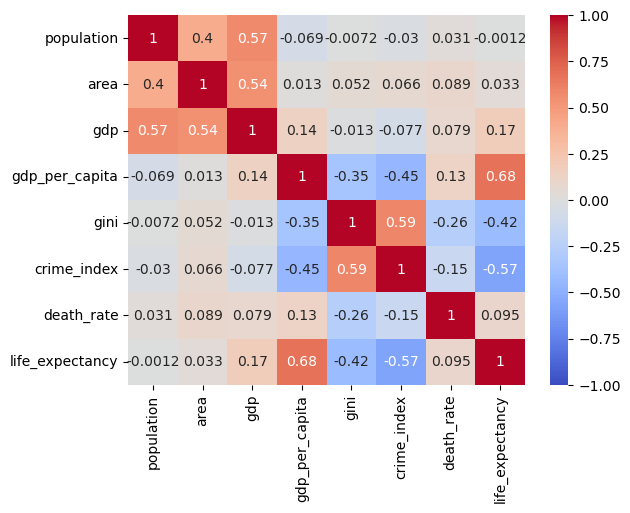

In [42]:
# Display correlation heatmap
corr_table = countries.corr(numeric_only=True)
sns.heatmap(corr_table, annot=True, cmap='coolwarm', vmin=-1)
plt.show()

## Step 4 - Data Analysis

#### Q1 - What are the 10 most populated countries?

In [45]:
# Data
top_10_pop_countries = countries \
    .nlargest(n=10, columns='population')[['name', 'population']] \
    .set_index('name')
top_10_pop_countries

,population
name,
China,1402112000
India,1380004385
United States,329484123
Indonesia,273523621
Pakistan,220892331
Brazil,212559409
Nigeria,206139587
Bangladesh,164689383
Russia,144104080


In [46]:
# Calculate the proportion of China and India population
chi_and_ind_pop = countries[(countries['name'] == 'China') | (countries['name'] == 'India')]['population'].sum()
world_pop = countries['population'].sum()
proportion = '{:.0%}'.format(chi_and_ind_pop / world_pop)

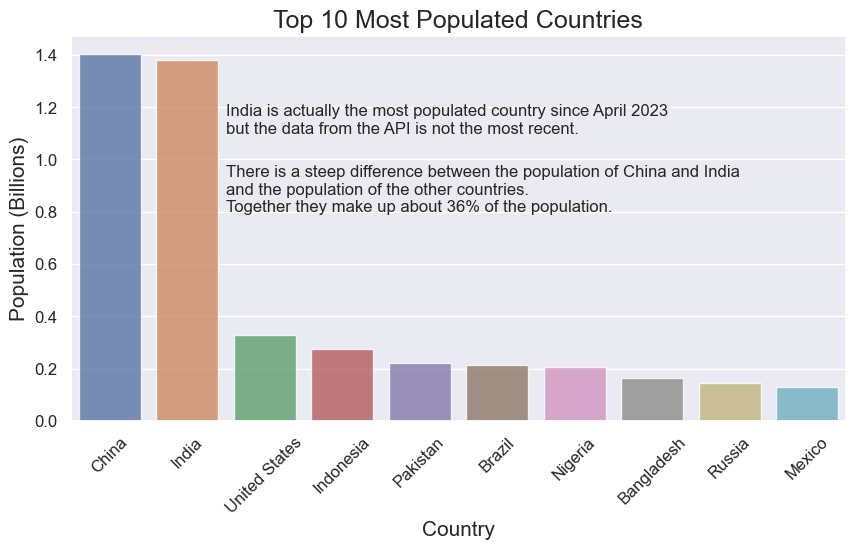

In [47]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_10_pop_countries,
                 x=top_10_pop_countries.index,
                 y=top_10_pop_countries['population'],
                 hue=top_10_pop_countries.index,
                 alpha=0.8)

# labels
ax.set_title('Top 10 Most Populated Countries', fontsize=18)
ax.set_xlabel('Country')
ax.set_ylabel('Population (Billions)')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', rotation=45)

# annotate plot
ax.text(1.5, 1100000000, "India is actually the most populated country since April 2023\nbut the data from the API is not the most recent.")
ax.text(1.5, 800000000, "There is a steep difference between the population of China and India\nand the population of the other countries.\nTogether they make up about {} of the population.".format(proportion))

# remove scientific notation showing at the top of the y axis
ax.yaxis.offsetText.set_visible(False)

plt.show()

#### Q2 - What are the most populated country per subregion?

In [49]:
countries \
    .sort_values(by=['continent', 'population'], ascending=[True, False]) \
    .groupby('subregion') \
    .head(1)[['subregion', 'name', 'population']] \
    .reset_index(drop=True)

,subregion,name,population
0,Western Africa,Nigeria,206139587
1,Eastern Africa,Ethiopia,114963583
2,Middle Africa,DR Congo,108407721
3,Northern Africa,Egypt,102334403
4,Southern Africa,South Africa,59308690
5,North America,United States,329484123
6,South America,Brazil,212559409
7,Central America,Guatemala,16858333
8,Caribbean,Haiti,11402533
9,Eastern Asia,China,1402112000


#### Q3 - What is the least populated continent?

In [51]:
total_pop_by_continent = countries.groupby('continent')['population'].sum()
continent = total_pop_by_continent.idxmin()
population = total_pop_by_continent[continent]
print('The least populated continent is', continent, 'with', population, 'people.')

The least populated continent is Antarctica with 1430 people.


#### Q4 - What are the top 20 largest countries?

In [53]:
# Data
top_20_largest_countries = countries \
    .nlargest(n=20, columns='area')[['name', 'area']] \
    .set_index('name')
top_20_largest_countries

,area
name,
Russia,17098242.00
Antarctica,14000000.00
Canada,9984670.00
China,9706961.00
United States,9372610.00
Brazil,8515767.00
Australia,7692024.00
India,3287590.00
Argentina,2780400.00


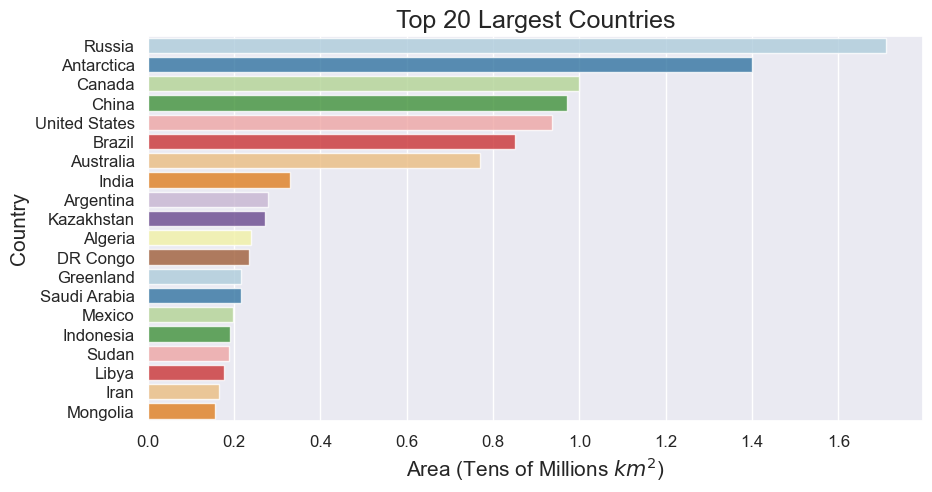

In [54]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_20_largest_countries,
                 x=top_20_largest_countries['area'],
                 y=top_20_largest_countries.index,
                 hue=top_20_largest_countries.index,
                 alpha=0.8,
                 palette='Paired',
                 orient='h')

# labels
ax.set_title('Top 20 Largest Countries', fontsize=18)
ax.set_xlabel('Area (Tens of Millions $km^2$)')
ax.set_ylabel('Country')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)

# remove scientific notation showing at the end of the x axis
ax.xaxis.offsetText.set_visible(False)

plt.show()

#### Q5 - What is the smallest continent?

In [56]:
total_area_by_continent = countries.groupby('continent')['area'].sum()
continent = total_area_by_continent.idxmin()
area = round(total_area_by_continent[continent])
print('The smallest continent is', continent, 'which is', area, 'square kilometers.')

The smallest continent is Oceania which is 8515313 square kilometers.


#### Q6 - What are the top 10 most common languages?

In [58]:
# Data
top_languages = countries['languages'].str.split(', ', expand=True).stack().value_counts().nlargest(n=10)
top_languages = pd.DataFrame(top_languages).rename(columns={'count': 'Number of Countries'})
top_languages

,Number of Countries
English,91
French,46
Arabic,25
Spanish,24
Portuguese,10
Dutch,7
Russian,7
German,6
Chinese,5
Swahili,4


#### Q7 - What is the proportion of countries driving on the left side for each continent?

In [60]:
# Data
car_side_per_continent = countries \
    .groupby('continent') \
    .agg(left_side=('car_side', lambda x: (x == 'left').sum()),
        right_side=('car_side', lambda x: (x == 'right').sum())) \
    .rename(columns={'left_side': 'Left Side', 'right_side': 'Right Side'})
car_side_per_continent

,Left Side,Right Side
continent,,
Africa,15,44
Americas,19,37
Antarctica,0,5
Asia,16,34
Europe,7,46
Oceania,17,10


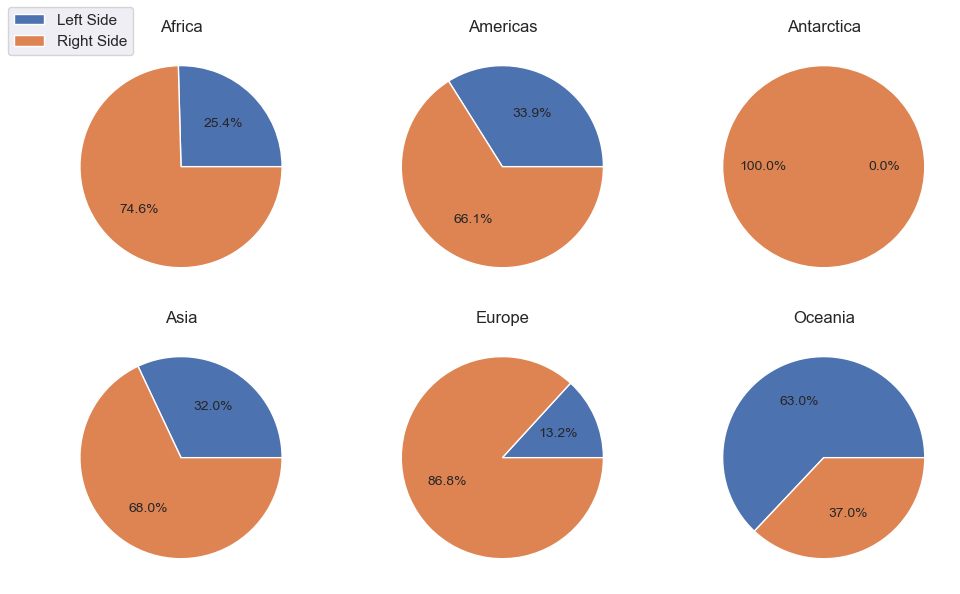

In [61]:
# Visualization
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

for i, (idx, row) in enumerate(car_side_per_continent.iterrows()):
    ax = axes[i // 3, i % 3]
    ax.pie(row, autopct='%1.1f%%', textprops={'fontsize': 10})
    ax.set_title(idx)

fig.legend(labels=car_side_per_continent.columns, loc='upper left')
fig.tight_layout()
plt.show()

#### Q8 - What are the 10 countries with the least inequalities?

In [63]:
countries.nsmallest(n=10, columns='gini')[['name', 'subregion', 'gini']]

,name,subregion,gini
201,Slovenia,Central Europe,24.60
56,Czechia,Central Europe,25.00
200,Slovakia,Central Europe,25.00
19,Belarus,Eastern Europe,25.30
142,Moldova,Eastern Europe,25.70
233,United Arab Emirates,Western Asia,26.00
99,Iceland,Northern Europe,26.10
14,Azerbaijan,Western Asia,26.60
232,Ukraine,Eastern Europe,26.60
20,Belgium,Western Europe,27.20


#### Q9 - What are the 10 countries with the highest mortality rate?

In [65]:
countries.nlargest(n=10, columns='death_rate')[['name', 'subregion', 'death_rate']]

,name,subregion,death_rate
232,Ukraine,Eastern Europe,18.60
126,Lithuania,Northern Europe,15.20
195,Serbia,Southeast Europe,14.90
120,Latvia,Northern Europe,14.70
180,Romania,Southeast Europe,14.60
98,Hungary,Central Europe,14.50
33,Bulgaria,Southeast Europe,14.20
142,Moldova,Eastern Europe,14.20
181,Russia,Eastern Europe,14.00
19,Belarus,Eastern Europe,13.30


#### Q10 - What is the subregion with the highest crime index?

In [67]:
avg_crime_index_per_subregion = countries.groupby('subregion')['crime_index'].mean()
subregion = avg_crime_index_per_subregion.idxmax()
crime_index = round(avg_crime_index_per_subregion[subregion])
print('The subregion with the highest crime index is {} which is {}.'.format(subregion, crime_index))

The subregion with the highest crime index is Melanesia which is 68.


#### Q11 - Does inequality cause high crime?

Based on the correlation table, the GINI Index is the most correlated to the Crime Index (0.59) compared to the other variables.

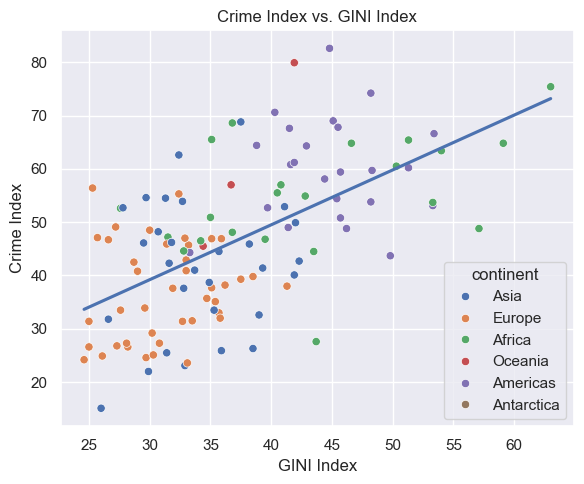

In [70]:
sns.set(rc={'figure.figsize': (6, 5)})
scatter = sns.scatterplot(data=countries, x='gini', y='crime_index', hue='continent')
reg = sns.regplot(data=countries, x='gini', y='crime_index', scatter=False, ci=False, ax=scatter)
reg.set_title('Crime Index vs. GINI Index')
reg.set_xlabel('GINI Index')
reg.set_ylabel('Crime Index')
plt.tight_layout()
plt.show()

The correlation between the two variables is linear. I think it's reasonable to say that a country is most likely to have higher crime if there is inequality.

#### Q12 - What is the overall average life expectancy?

In [73]:
avg_life_exp = round(countries['life_expectancy'].mean(), 2)
print('The overall average life expectancy is', avg_life_exp, 'years.')

The overall average life expectancy is 73.78 years.


#### Q13 - What variables seem to be correlated to life expectancy the most?

The Crime Index and the GDP per Capita are the variables that are the most correlated to the Life Expectancy (-0.57 and 0.68 respectively).

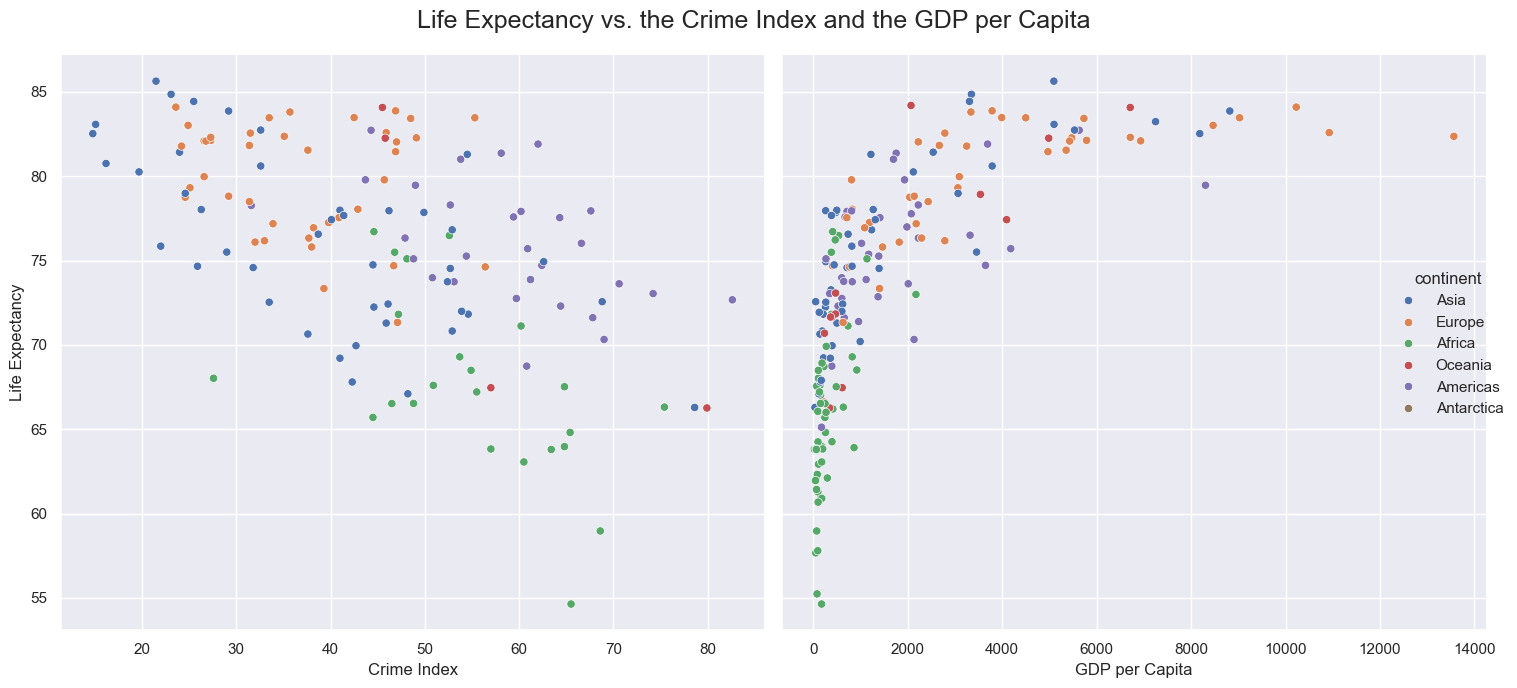

In [76]:
# Display plot of Life Expectancy over the other variables
df = countries.rename(columns={'life_expectancy': 'Life Expectancy',
                                'crime_index': 'Crime Index',
                                'gdp_per_capita': 'GDP per Capita'})

ax = sns.pairplot(data=df,
                 x_vars=['Crime Index', 'GDP per Capita'],
                 y_vars=['Life Expectancy'],
                 hue='continent',
                 height=7)
ax.fig.suptitle('Life Expectancy vs. the Crime Index and the GDP per Capita', fontsize=18)
plt.tight_layout()
plt.show()

We can see that the plot with the Crime Index is more linear and the plot with the GDP per capita is more logarithmic. I think it makes sense those variables have a stonger correlation because a country with less crime and more wealth usually means a country with a better quality of life, which also leads to a longer life.

## End